In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [129]:
df = pd.read_csv("MI_DB.csv", index_col=0)
# Replace to NaN and convert to float
df = df.replace("?", np.nan)
df = df.apply(pd.to_numeric)

In [130]:
record_count = df.count().to_numpy()
indexes_high_na = np.where( record_count < 1700/2)[0]

name_dropped = df.columns[indexes_high_na].to_numpy() #Keep track of the names of the columns we drop
df = df.drop(df.columns[indexes_high_na], axis = 1)



In [131]:
treshold_na = int(0.3*119) # if more that 50% of missing values, get rid of the row (59)
print("Treshold:",treshold_na)

def calculate_NA(row):
    return row.isna().sum().sum()

df["n_NA"] = df.apply(calculate_NA, axis=1)

np.max(df["n_NA"])

df = df.drop(df[df["n_NA"] > treshold_na].index)
df = df.drop(["n_NA"], axis=1)

df["DEAD"] = df["LET_IS"].apply(lambda x: 1 if x > 0 else 0)

Treshold: 35


In [132]:
numeric_attributes = ["AGE","S_AD_KBRIG","D_AD_KBRIG","S_AD_ORIT","D_AD_ORIT","K_BLOOD","NA_BLOOD",
                      "ALT_BLOOD","AST_BLOOD","KFK_BLOOD","L_BLOOD","ROE"]

numeric_attributes = [x for x in numeric_attributes if x not in name_dropped]

ord_attributes = ["INF_ANAM","STENOK_AN","FK_STENOK","IBS_POST","GB","DLIT_AG","ZSN_A",
                  "ant_im","lat_im","inf_im","post_im","R_AB_1_n","NA_R_1_n","NOT_NA_1_n",
                 "R_AB_2_n","NA_R_2_n","NOT_NA_2_n","R_AB_3_n","NA_R_3_n","NOT_NA_3_n","TIME_B_S"]


ord_attributes = [x for x in ord_attributes if x not in name_dropped]

Y_labels = ["FIBR_PREDS","PREDS_TAH","JELUD_TAH","FIBR_JELUD","A_V_BLOK","OTEK_LANC","RAZRIV","DRESSLER","ZSN","REC_IM","P_IM_STEN","LET_IS","DEAD"]

att_names = list(df.columns)

bin_attributes = [x for x in att_names if x not in numeric_attributes+ord_attributes+Y_labels]
bin_attributes = [x for x in bin_attributes if x not in name_dropped]

colums_id_Y = [df.columns.get_loc(c) for c in Y_labels if c in df]

In [133]:
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

scaler = preprocessing.StandardScaler()

pipe = make_pipeline(scaler, KNNImputer(n_neighbors=10))

imputer = KNNImputer(n_neighbors=3)
df_i = pipe.fit_transform(df)
df_i = scaler.inverse_transform(df_i)

sf_df = pd.DataFrame(df_i, index=df.index, columns=df.columns)

In [134]:
sf_df[ord_attributes]= sf_df[ord_attributes].apply(round,axis=1)

sf_df[bin_attributes]= sf_df[bin_attributes].apply(round,axis=1)

sf_df_dum = pd.get_dummies(sf_df, columns=ord_attributes)

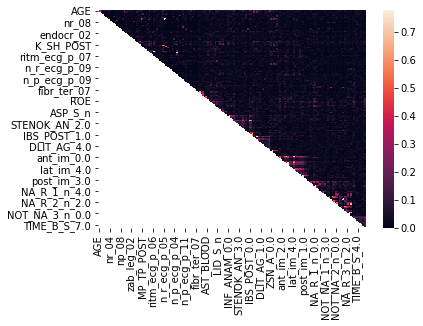

In [135]:
x_cols = bin_attributes+ord_attributes+numeric_attributes
y_cols = Y_labels


x_cols = [x for x in sf_df_final.columns if x not in Y_labels]

X = sf_df_final[x_cols]
Y = sf_df_final[y_cols]

cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

X = X.drop(to_drop, axis=1)
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
sns.heatmap(upper_tri)

scaler.fit(X)
X_sc = scaler.transform(X)
Y_dead = Y["DEAD"].to_numpy()
Y_dead = Y_dead.round().astype(int)

In [136]:
X_sc.shape

(1688, 174)

In [114]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
ros = RandomOverSampler(random_state=0)
smo = SMOTE()

# Fit LDA

Fitting 15 folds for each of 60 candidates, totalling 900 fits


/Users/stephaneguichard/python-projects/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.5602912  0.91585872 0.91585872 0.91585872 0.91585872 0.91585872
 0.91585872 0.91585872 0.91585872 0.91585872 0.91585872 0.91585872
 0.91585872 0.91585872 0.91585872 0.91585872 0.91585872 0.91585872
 0.91585872 0.91589788        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.91577649 0.91577649
 0.91577649 0.91577649 0.91577649 0.91577649 0.91577649 0.91577649
 0.91577649 0.91577649 0.91577649 0.91577649 0.91577649 0.91577649
 0.91577649 0.91577649 0.91577649 0.91577649 0.91577649 0.91577649]
  warnings.warn(


best estimator: Pipeline(steps=[('LDA', LinearDiscriminantAnalysis(tol=0.06))])
Fitting 15 folds for each of 60 candidates, totalling 900 fits


/Users/stephaneguichard/python-projects/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.55331784 0.9306332  0.9306332  0.9306332  0.9306332  0.9306332
 0.9306332  0.9306332  0.9306332  0.9306332  0.9306332  0.9306332
 0.9306332  0.9306332  0.93073024 0.93073024 0.93073024 0.93073024
 0.93073024 0.93066768        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.93046082 0.93046082
 0.93046082 0.93046082 0.93046082 0.93046082 0.93046082 0.93046082
 0.93046082 0.93046082 0.93046082 0.93046082 0.93046082 0.93046082
 0.93046082 0.93046082 0.93046082 0.93046082 0.93046082 0.93046082]
  warnings.warn(


best estimator: Pipeline(steps=[('LDA', LinearDiscriminantAnalysis(tol=0.04421052631578947))])
Fitting 15 folds for each of 60 candidates, totalling 900 fits


/Users/stephaneguichard/python-projects/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.56417752 0.92121305 0.92121305 0.92121305 0.92121305 0.92121305
 0.92121305 0.92121305 0.92121305 0.92121305 0.92121305 0.92121305
 0.92121305 0.92121305 0.92121305 0.92121305 0.92121305 0.92121305
 0.92121305 0.92128424        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.92145586 0.92145586
 0.92145586 0.92145586 0.92145586 0.92145586 0.92145586 0.92145586
 0.92145586 0.92145586 0.92145586 0.92145586 0.92145586 0.92145586
 0.92145586 0.92145586 0.92145586 0.92145586 0.92145586 0.92145586]
  warnings.warn(


best estimator: Pipeline(steps=[('LDA', LinearDiscriminantAnalysis(solver='lsqr', tol=0.0))])
Fitting 15 folds for each of 60 candidates, totalling 900 fits


/Users/stephaneguichard/python-projects/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.55161108 0.92192632 0.92192632 0.92192632 0.92192632 0.92192632
 0.92192632 0.92192632 0.92192632 0.92192632 0.92192632 0.92192632
 0.92192632 0.92193282 0.92193282 0.92193282 0.92193282 0.92193282
 0.92193282 0.92194061        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.92304153 0.92304153
 0.92304153 0.92304153 0.92304153 0.92304153 0.92304153 0.92304153
 0.92304153 0.92304153 0.92304153 0.92304153 0.92304153 0.92304153
 0.92304153 0.92304153 0.92304153 0.92304153 0.92304153 0.92304153]
  warnings.warn(


best estimator: Pipeline(steps=[('LDA', LinearDiscriminantAnalysis(solver='lsqr', tol=0.0))])
Fitting 15 folds for each of 60 candidates, totalling 900 fits


/Users/stephaneguichard/python-projects/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.55686485 0.9133954  0.9133954  0.9133954  0.9133954  0.9133954
 0.9133954  0.9133954  0.9133954  0.9133954  0.9133954  0.9133954
 0.9133954  0.9133954  0.9133954  0.9133954  0.9133954  0.9133954
 0.9133954  0.91342683        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.91281522 0.91281522
 0.91281522 0.91281522 0.91281522 0.91281522 0.91281522 0.91281522
 0.91281522 0.91281522 0.91281522 0.91281522 0.91281522 0.91281522
 0.91281522 0.91281522 0.91281522 0.91281522 0.91281522 0.91281522]
  warnings.warn(


best estimator: Pipeline(steps=[('LDA', LinearDiscriminantAnalysis(tol=0.06))])
0.6713447205849423


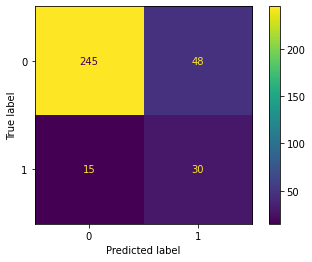

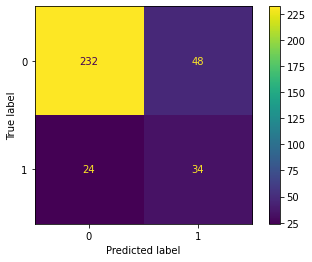

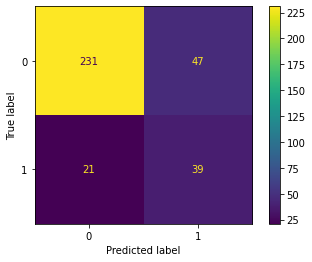

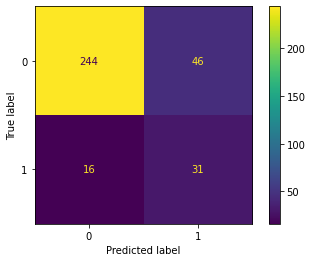

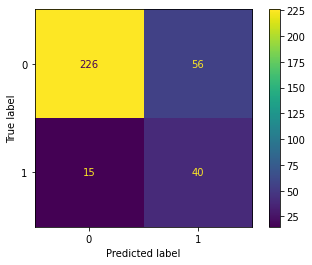

In [41]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score,plot_confusion_matrix
from sklearn.pipeline import Pipeline

inner_cv = KFold(n_splits=5, shuffle=True)
scores = []
models = []

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_sc)):
    x_train, x_test = X_sc[train_ids],X_sc[test_ids]
    y_train, y_test = Y_dead[train_ids],Y_dead[test_ids]
    
    x_train, y_train =  ros.fit_resample(x_train, y_train)
    
    param_grid = {
        "LDA__solver": ["svd", "eigen","lsqr"],
        "LDA__shrinkage": [None],
        "LDA__tol" : np.linspace(0,0.06,20)
    }

    model = Pipeline([("LDA",LinearDiscriminantAnalysis())])
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

    cv_grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = cv, verbose=2, n_jobs=-1,scoring="roc_auc")

    cv_grid.fit(x_train, y_train)
    print(f'best estimator: {cv_grid.best_estimator_}')
    models.append(cv_grid.best_estimator_)

    y_pred = cv_grid.predict(x_test)
    plot_confusion_matrix(cv_grid, x_test, y_test)  
    scores.append(balanced_accuracy_score(y_pred,y_test))

print(np.mean(scores))

In [38]:
for mod in models:
    name, model_lda = mod.steps[0]
    print(model_lda.get_params())

{'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': 'auto', 'solver': 'lsqr', 'store_covariance': False, 'tol': 0.0}
{'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': 'auto', 'solver': 'lsqr', 'store_covariance': False, 'tol': 0.0}
{'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.044444444444444446}
{'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': 'auto', 'solver': 'eigen', 'store_covariance': False, 'tol': 0.0}
{'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.011111111111111112}


In [37]:
np.linspace(0,0.1,10)

array([0.        , 0.01111111, 0.02222222, 0.03333333, 0.04444444,
       0.05555556, 0.06666667, 0.07777778, 0.08888889, 0.1       ])

## Quadratic LDA

Fitting 15 folds for each of 20 candidates, totalling 300 fits


/Users/stephaneguichard/python-projects/venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


best estimator: Pipeline(steps=[('LDA',
                 QuadraticDiscriminantAnalysis(reg_param=0.02631578947368421))])
Fitting 15 folds for each of 20 candidates, totalling 300 fits


/Users/stephaneguichard/python-projects/venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


best estimator: Pipeline(steps=[('LDA',
                 QuadraticDiscriminantAnalysis(reg_param=0.02631578947368421))])
Fitting 15 folds for each of 20 candidates, totalling 300 fits


/Users/stephaneguichard/python-projects/venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


best estimator: Pipeline(steps=[('LDA',
                 QuadraticDiscriminantAnalysis(reg_param=0.02631578947368421))])
Fitting 15 folds for each of 20 candidates, totalling 300 fits


/Users/stephaneguichard/python-projects/venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


best estimator: Pipeline(steps=[('LDA',
                 QuadraticDiscriminantAnalysis(reg_param=0.02631578947368421))])
Fitting 15 folds for each of 20 candidates, totalling 300 fits
best estimator: Pipeline(steps=[('LDA',
                 QuadraticDiscriminantAnalysis(reg_param=0.02631578947368421))])
0.6644474713448733


/Users/stephaneguichard/python-projects/venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


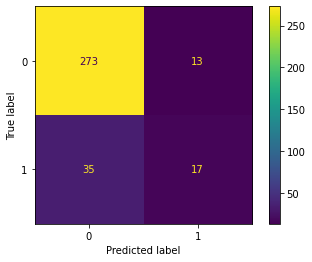

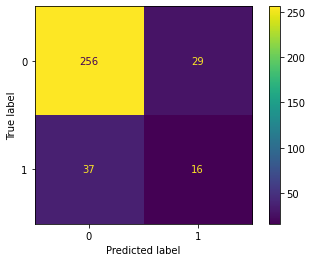

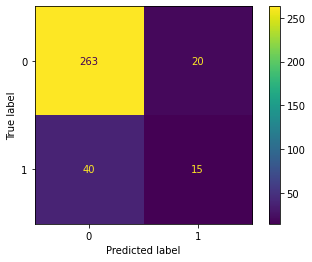

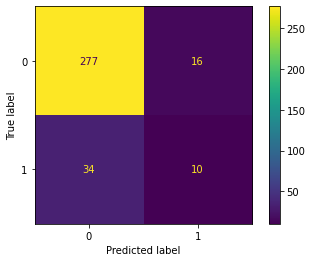

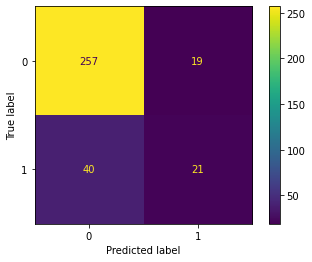

In [44]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score,plot_confusion_matrix
from sklearn.pipeline import Pipeline

inner_cv = KFold(n_splits=5, shuffle=True)
scores = []
models = []

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_sc)):
    x_train, x_test = X_sc[train_ids],X_sc[test_ids]
    y_train, y_test = Y_dead[train_ids],Y_dead[test_ids]
    
    x_train, y_train =  ros.fit_resample(x_train, y_train)
    
    param_grid = {
        "LDA__reg_param": np.linspace(0,0.5,20)
    }

    model = Pipeline([("LDA",QuadraticDiscriminantAnalysis())])
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

    cv_grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = cv, verbose=2, n_jobs=-1,scoring="roc_auc")

    cv_grid.fit(x_train, y_train)
    print(f'best estimator: {cv_grid.best_estimator_}')
    models.append(cv_grid.best_estimator_)

    y_pred = cv_grid.predict(x_test)
    plot_confusion_matrix(cv_grid, x_test, y_test)  
    scores.append(balanced_accuracy_score(y_pred,y_test))

print(np.mean(scores))

# Get some curves with LDA

In [224]:
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score, confusion_matrix, accuracy_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    

reg_param =np.linspace(0,1,100)
inner_cv = KFold(n_splits=5, shuffle=True)


auc_r = []
sen_t = []
spe_t = []
b_a =[]

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_sc)):
    x_train_l, x_test_l = X_sc[train_ids],X_sc[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    for reg_p in reg_param:

        mdl = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=reg_p)
        mdl.fit(x_train_l, y_train_l)
        probs = mdl.predict_proba(x_test_l)
        probs = probs[:, 1]
        auc = roc_auc_score(y_test_l, probs)
        y_pred = mdl.predict(x_test_l)
        tn, fp, fn, tp = confusion_matrix(y_test_l,y_pred).ravel()
        

        auc_r.append(auc)
        sen_t.append(tp/(tp+fn))
        spe_t.append(tn/(tn+fp))
        b_a.append(balanced_accuracy_score(y_test_l,y_pred))
    break;



Text(0.5, 0, 'Shrinkage parameter')

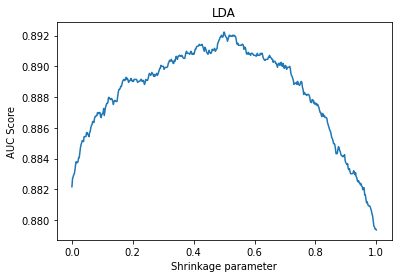

In [212]:

plt.plot(reg_param,auc_r)
plt.title("LDA")
plt.ylabel("AUC Score")
plt.xlabel("Shrinkage parameter")

Text(0.5, 0, 'Shrinkage parameter')

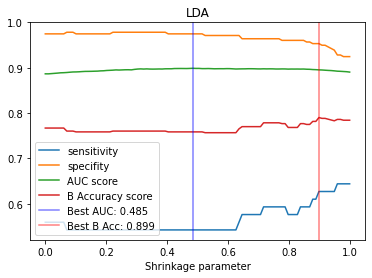

In [226]:

plt.plot(reg_param,sen_t,label="sensitivity")
plt.plot(reg_param,spe_t,label="specifity")
plt.plot(reg_param,auc_r,label="AUC score")
plt.plot(reg_param,b_a,label="B Accuracy score")
plt.axvline(reg_param[np.argmax(auc_r)], 0, 1, label='Best AUC: {:.3f}'.format(reg_param[np.argmax(auc_r)]), color="b", alpha=0.5)
plt.axvline(reg_param[np.argmax(b_a)], 0, 1, label='Best B Acc: {:.3f}'.format(reg_param[np.argmax(b_a)]), color="r", alpha=0.5)
plt.legend()
plt.title("LDA")
plt.xlabel("Shrinkage parameter")

In [245]:
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score, confusion_matrix, accuracy_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    

reg_param =np.linspace(0,1,100)
inner_cv = KFold(n_splits=5, shuffle=True)

sp =np.linspace(0,1,100)
priors = [[item, 1-item] for item in sp]

auc_r = []
sen_t = []
spe_t = []
b_a =[]

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_sc)):
    x_train_l, x_test_l = X_sc[train_ids],X_sc[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    

    for prior in priors:
        mdl = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=0.899, priors=prior)
        mdl.fit(x_train_l, y_train_l)
        probs = mdl.predict_proba(x_test_l)
        probs = probs[:, 1]
        auc = roc_auc_score(y_test_l, probs)
        y_pred = mdl.predict(x_test_l)
        tn, fp, fn, tp = confusion_matrix(y_test_l,y_pred).ravel()


        auc_r.append(auc)
        sen_t.append(tp/(tp+fn))
        spe_t.append(tn/(tn+fp))
        b_a.append(balanced_accuracy_score(y_test_l,y_pred))

    break;


/Users/stephaneguichard/python-projects/venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:363: RuntimeWarning: divide by zero encountered in log
  np.log(self.priors_))
/Users/stephaneguichard/python-projects/venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:363: RuntimeWarning: divide by zero encountered in log
  np.log(self.priors_))


Text(0.5, 0, 'Priors')

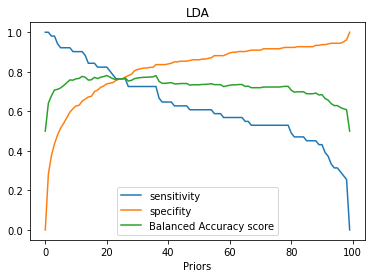

In [249]:

plt.plot(sen_t,label="sensitivity")
plt.plot(spe_t,label="specifity")
plt.plot(b_a,label="Balanced Accuracy score")

plt.legend()
plt.title("LDA")
plt.xlabel("Priors")

In [251]:
priors[20]

[0.20202020202020204, 0.797979797979798]

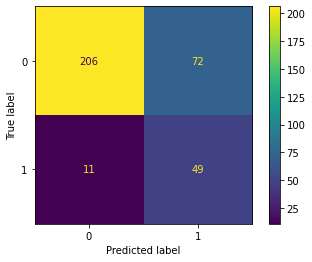

In [270]:
for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_sc)):
    x_train_l, x_test_l = X_sc[train_ids],X_sc[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    mdl = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=0.899, priors=priors[20])
    mdl.fit(x_train_l, y_train_l)
    plot_confusion_matrix(mdl, x_test_l, y_test_l)  

    break;

# Grid search of LDA with shrinkage parameter and priors

In [356]:
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score, confusion_matrix, accuracy_score



reg_param =np.linspace(0,1,120)
inner_cv = KFold(n_splits=5, shuffle=True)

sp =np.linspace(0.01,0.99,120)
priors = [[item, 1-item] for item in sp]

auc_r = []
sen_t = []
spe_t = []
b_a =[]

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_sc)):
    x_train_l, x_test_l = X_sc[train_ids],X_sc[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    for idx,prior in enumerate(priors):
        print(idx)
        auc_r_p = []
        sen_p = []
        spe_p = []
        b_a_p = []
        for reg_p in reg_param:
            mdl = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=reg_p, priors=prior)
            mdl.fit(x_train_l, y_train_l)
            probs = mdl.predict_proba(x_test_l)
            probs = probs[:, 1]
            auc = roc_auc_score(y_test_l, probs)
            y_pred = mdl.predict(x_test_l)
            tn, fp, fn, tp = confusion_matrix(y_test_l,y_pred).ravel()


            auc_r_p.append(auc)
            sen_p.append(tp/(tp+fn))
            spe_p.append(tn/(tn+fp))
            b_a_p.append(balanced_accuracy_score(y_test_l,y_pred))
            
        auc_r.append(auc_r_p)
        sen_t.append(sen_p)
        spe_t.append(spe_p)
        b_a.append(b_a_p)

    break;


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


([<matplotlib.axis.YTick at 0x140f13940>,
 [Text(0, 0, '0, 1'), Text(0, 30, '1, 0')])

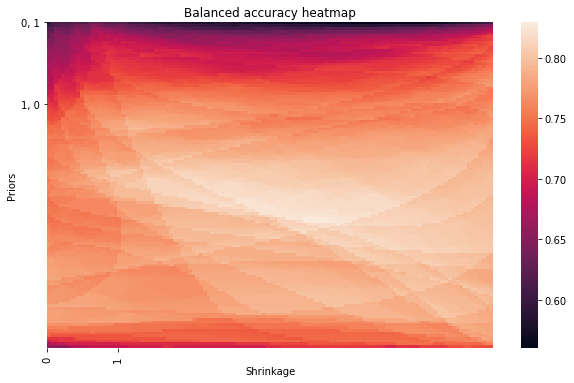

In [357]:
plt.rcParams["figure.figsize"] = (10,6)
sns.heatmap(b_a)

plt.title("Balanced accuracy heatmap")
plt.xlabel("Shrinkage")
plt.ylabel("Priors")
plt.xticks([0,19],["0","1"])
plt.yticks([0,30],["0, 1","1, 0"])

([<matplotlib.axis.YTick at 0x1409b3fa0>,
 [Text(0, 0, '0, 1'), Text(0, 30, '1, 0')])

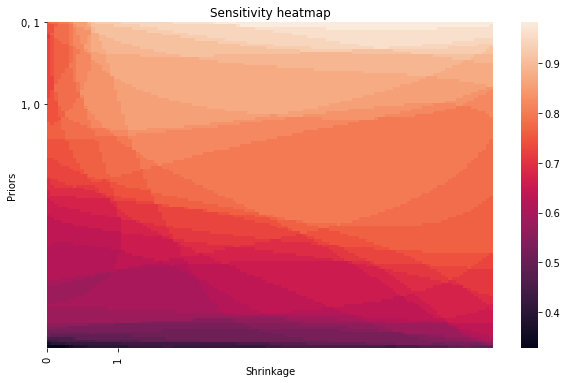

In [358]:
sns.heatmap(sen_t)
plt.title("Sensitivity heatmap")
plt.xlabel("Shrinkage")
plt.ylabel("Priors")
plt.xticks([0,19],["0","1"])
plt.yticks([0,30],["0, 1","1, 0"])

([<matplotlib.axis.YTick at 0x13d7af970>,
 [Text(0, 0, '0, 1'), Text(0, 30, '1, 0')])

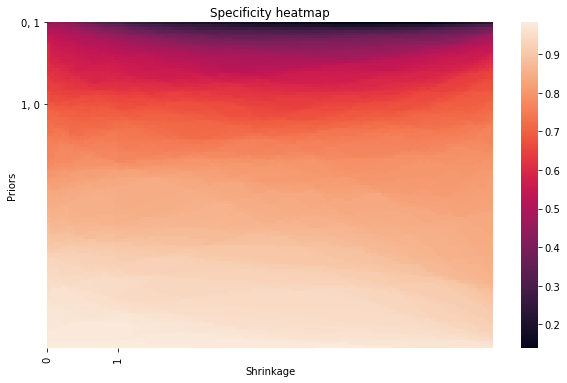

In [359]:
sns.heatmap(spe_t)
plt.title("Specificity heatmap")
plt.xlabel("Shrinkage")
plt.ylabel("Priors")
plt.xticks([0,19],["0","1"])
plt.yticks([0,30],["0, 1","1, 0"])

# CM for max sensitivity

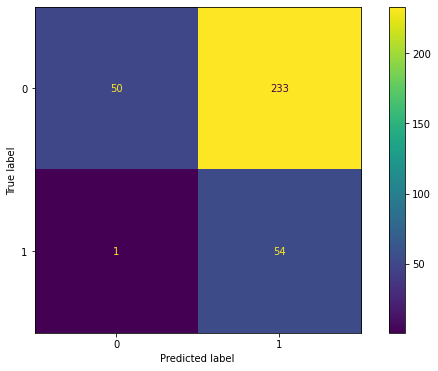

In [371]:
args = np.argwhere(sen_t==np.max(sen_t))

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_sc)):
    x_train_l, x_test_l = X_sc[train_ids],X_sc[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    mdl = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=reg_param[args[0][1]], priors=priors[args[0][0]])
    mdl.fit(x_train_l, y_train_l)
    plot_confusion_matrix(mdl, x_test_l, y_test_l)  

    break;

# Max specificity

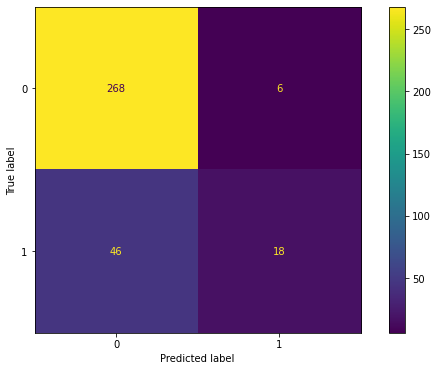

In [368]:
args = np.argwhere(spe_t==np.max(spe_t))

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_sc)):
    x_train_l, x_test_l = X_sc[train_ids],X_sc[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    mdl = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=reg_param[args[0][1]], priors=priors[args[0][0]])
    mdl.fit(x_train_l, y_train_l)
    plot_confusion_matrix(mdl, x_test_l, y_test_l)  

    break;

# Max Balanced accuracy

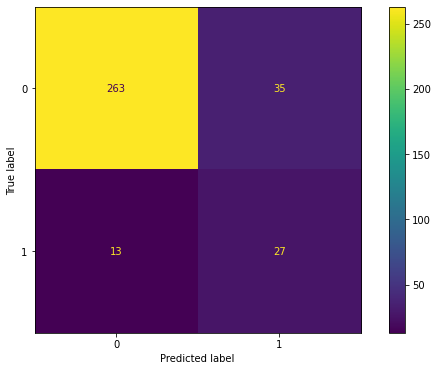

In [367]:
args = np.argwhere(b_a==np.max(b_a))

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_sc)):
    x_train_l, x_test_l = X_sc[train_ids],X_sc[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    mdl = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=reg_param[args[0][1]], priors=priors[args[0][0]])
    mdl.fit(x_train_l, y_train_l)
    plot_confusion_matrix(mdl, x_test_l, y_test_l)  

    break;

### Note

We decided as student to choose balanced accuracy as our best metric, but it would be best to see with a medical specialist what is prefered as a sensitivity / specificity balance